# New dynasor python API demo
Here a short demo using the new `dynasor` python API is presented.    
Note working in progress.
![](logo.svg)

https://dynasor.materialsmodeling.org/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [2]:
from dynasor.trajectory import Trajectory
from dynasor.isotropic import generate_spherical_qpoints
from dynasor.correlation_functions import compute_dynamic_structure_factors

In [3]:
# set log level
from dynasor.logging_tools import set_logging_level
set_logging_level('INFO')

### Define trajectory
Multiple different trajectory formats are supported (via `mdanalysis` and `ase` readers)

In [4]:
traj_fname = 'dump.xyz'
traj = Trajectory(traj_fname, trajectory_format='xyz_ase_internal')

### Define q-points to sample
Here, we consider q-points on a 3D meshgrid 

In [5]:
# setup q-points
q_max = 30
q_points = generate_spherical_qpoints(traj.cell, q_max=q_max)

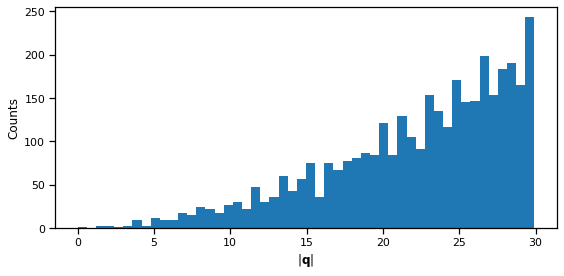

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(np.linalg.norm(q_points, axis=1), bins=50)
plt.xlabel(r'$|\mathbf{q}|$')
plt.ylabel('Counts')
plt.tight_layout();

## Run dynamical structure factor calculation (main calculation)

In [7]:
# time sampling parameters
dt = 1.0
window_size = 10

# run 
results = compute_dynamic_structure_factors(traj, q_points, dt=dt, window_size=window_size)

INFO: Setting dt to 1.0 fs.
INFO: Setting time between consecutive frames (dt * frame_step) to 1.0 fs.
INFO: Time window is 10.0 fs
INFO: delta_omega, max_omega = 0.6283185307179586, 6.283185307179586 fs^-1
INFO: Trajectory file: dump.xyz
INFO: With a total of 1080 particles, 3 types.
INFO: 1. 216 Cs with density 3.824 nm^-3
INFO: 2. 216 Pb with density 3.824 nm^-3
INFO: 3. 648 I with density 11.472 nm^-3
INFO: Simulation box is
[[3.83688162 0.         0.        ]
 [0.         3.83688162 0.        ]
 [0.         0.         3.83688162]]
INFO: N kpoints = 3617


In [8]:
print(results)

Correlation function data:
F_q_t_Cs_Cs
F_q_t_Cs_I
F_q_t_Cs_Pb
F_q_t_I_I
F_q_t_Pb_I
F_q_t_Pb_Pb
F_q_t_tot
S_q_w_Cs_Cs
S_q_w_Cs_I
S_q_w_Cs_Pb
S_q_w_I_I
S_q_w_Pb_I
S_q_w_Pb_Pb
S_q_w_tot
q_points
t
w


Results object can written to file and read at a later point

In [9]:
from dynasor.sample import read_sample_from_npy
results.write_to_npy('test.npy')
results2 = read_sample_from_npy('test.npy')

## Analyze intermediate scattering function F(q, t) and dynamical structure factor S(q, w)
Next, we will read more converged results from a longer md trajectory for the cubic perovskite phase of CsPbI3.


In [10]:
invfs2mev = 658.2119  # angular frequency
results = read_sample_from_npy('dynasor_outputs/dynasor_size12_T600_dump25_nframes20000_window1000.npy')
time = results.t
omega = invfs2mev * results.w

In [11]:
# spherical average of F and S in time and frequency domain
q_bins = 100
q_bincenters, Fqt, bin_counts = results.compute_qpoint_spherical_average(q_bins=q_bins, key='F_q_t_tot')
q_bincenters, Sqw, bin_counts = results.compute_qpoint_spherical_average(q_bins=q_bins, key='S_q_w_tot')

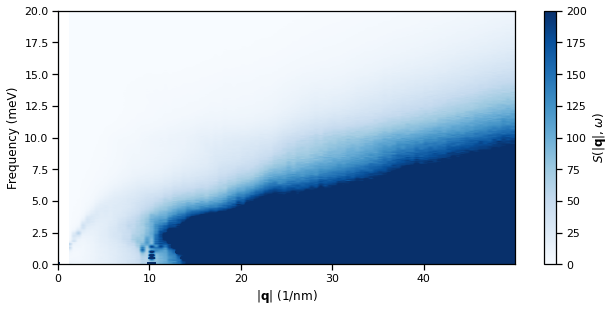

In [12]:
# heatmap
fig = plt.figure(figsize=(9, 4.5))
plt.imshow(Sqw.T, origin='lower', cmap='Blues', aspect='auto', extent=[0, q_bincenters.max(), 0, omega.max()])
plt.colorbar(label='$S(|\mathbf{q}|, \omega)$')
plt.clim([0, 200])
plt.ylim([0, 20])

plt.xlabel('$|\mathbf{q}|$ (1/nm)')
plt.ylabel('Frequency (meV)')

fig.tight_layout()

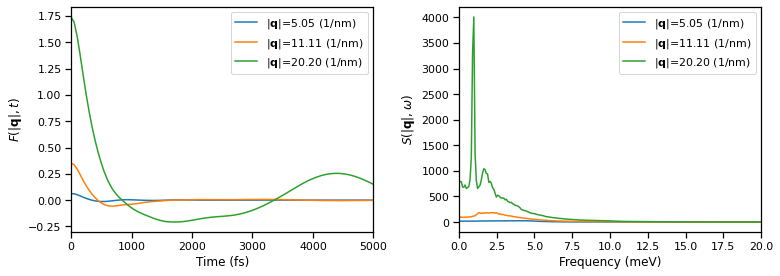

In [13]:
# slices in heatmap
q_inds = [10, 22, 40]

fig = plt.figure(figsize=(11, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for q_ind in q_inds:
    label=fr'$|\mathbf{{q}}|$={q_bincenters[q_ind]:.2f} (1/nm)'
    ax1.plot(time, Fqt[q_ind, :], label=label)
    ax2.plot(omega, Sqw[q_ind, :], label=label)

ax1.legend(loc=1)
ax2.legend(loc=1)

ax1.set_xlabel('Time (fs)')
ax1.set_ylabel('$F(|\mathbf{q}|, t)$')
ax2.set_xlabel('Frequency (meV)')
ax2.set_ylabel('$S(|\mathbf{q}|, \omega)$')

ax1.set_xlim([0, 5000])
ax2.set_xlim([0, 20])

fig.tight_layout()

In [14]:
# Extract the high-symmetry q-point R and X
alat=6.316052322219224
q_BZ = 2 * np.pi/(alat/10)

qpt_R = q_BZ * np.array([3/2, 1/2, 1/2])
q_ind_R = np.linalg.norm(results.q_points - qpt_R, axis=1).argmin()
assert np.allclose(results.q_points[q_ind_R], qpt_R)

qpt_X = q_BZ * np.array([1/2, 1, 0])
q_ind_X = np.linalg.norm(results.q_points - qpt_X, axis=1).argmin()
assert np.allclose(results.q_points[q_ind_X], qpt_X)

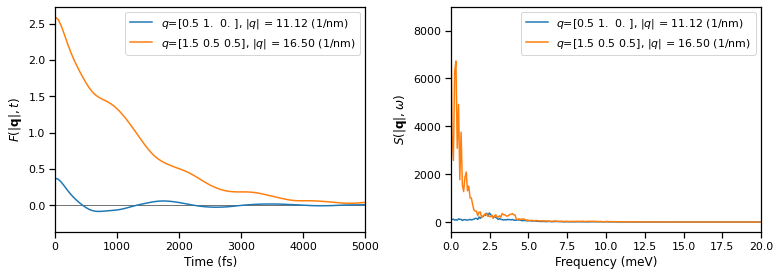

In [15]:
# Inspect F(q, t) and S(q, w) at specific q-points
q_inds = [q_ind_X, q_ind_R]

fig = plt.figure(figsize=(11, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.axhline(y=0, color='k', lw=0.9, alpha=0.6)
for q_ind in q_inds:
    q_norm = np.linalg.norm(results.q_points[q_ind])
    label=fr'$q$={np.round(results.q_points[q_ind]/q_BZ,2)}, $|q|$ = {q_norm:.2f} (1/nm)'
    
    ax1.plot(time, results['F_q_t_tot'][q_ind, :],  label=label)
    ax2.plot(omega, results['S_q_w_tot'][q_ind, :], label=label)

ax1.legend(loc=1)
ax2.legend(loc=1)

ax1.set_xlabel('Time (fs)')
ax1.set_ylabel('$F(|\mathbf{q}|, t)$')
ax2.set_xlabel('Frequency (meV)')
ax2.set_ylabel('$S(|\mathbf{q}|, \omega)$')

ax1.set_xlim([0, 5000])
ax2.set_xlim([0, 20])


fig.tight_layout()

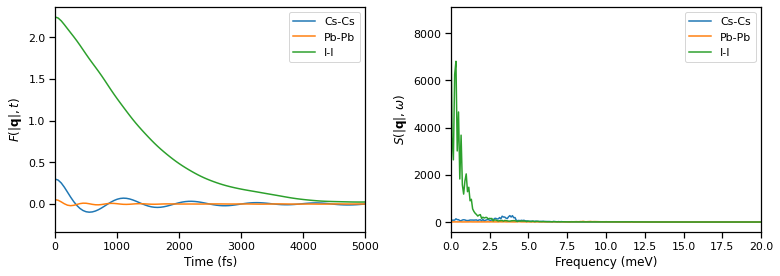

In [16]:
# for R-point
pairs = ['Cs_Cs', 'Pb_Pb', 'I_I']

fig = plt.figure(figsize=(11, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for pair in pairs:
    label = pair.replace('_', '-')
    F = results[f'F_q_t_{pair}'][q_ind_R, :]
    S = results[f'S_q_w_{pair}'][q_ind_R, :]
    ax1.plot(time, F, label=label)
    ax2.plot(omega, S, label=label)

ax1.legend(loc=1)
ax2.legend(loc=1)

ax1.set_xlabel('Time (fs)')
ax1.set_ylabel('$F(|\mathbf{q}|, t)$')
ax2.set_xlabel('Frequency (meV)')
ax2.set_ylabel('$S(|\mathbf{q}|, \omega)$')

ax1.set_xlim([0, 5000])
ax2.set_xlim([0, 20])


fig.tight_layout()